### Email spam or ham classification using Multinomial Naive Bayes

`spam` emails are unwanted emails. Where as, `ham` refers to non-spam.

We will install two libraries required to process natural language. 
- `nltk`: Natural Language Tool Kit developed by stanford NLP
- `spacy`: Another awesome library for NLP

In [ ]:
# !pip install nltk  
# !pip install spacy 

In [ ]:
# !python -m spacy download en_core_web_sm

#### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')  # download the stop-words in nltk
nltk.download('punkt_tab')  # used for word tokenizer
nlp = spacy.load("en_core_web_sm")   # will be used for lemmatization 

# Set the option to display full column width
pd.set_option('display.max_colwidth', 200)

# Set the option to display all columns
pd.set_option('display.max_columns', 50)

[nltk_data] Downloading package stopwords to C:\Users\Sourav
[nltk_data]     Karmakar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Sourav
[nltk_data]     Karmakar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Load data 

The data is obtained from [spam email dataset](https://www.kaggle.com/datasets/venky73/spam-mails-dataset) in kaggle, which contains labelled emails, with indications of whether they are spam or ham.

In [12]:
data = pd.read_csv("./spam_ham_dataset.csv")
data.head(10)

,label,text
0,ham,"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily vo..."
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls"
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !\r\ni know that this time of year is extremely hectic , and that it ' s ..."
3,spam,"Subject: photoshop , windows , office . cheap . main trending\r\nabasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nir..."
4,ham,"Subject: re : indian springs\r\nthis deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\np..."
5,ham,"Subject: ehronline web address change\r\nthis message is intended for ehronline users only .\r\ndue to a recent change to ehronline , the url ( aka "" web address "" ) for accessing ehronline needs ..."
6,ham,"Subject: spring savings certificate - take 30 % off\r\nsave 30 % when you use our customer appreciation spring savings\r\ncertificate at foot locker , lady foot locker , kids foot locker and at\r\..."
7,spam,"Subject: looking for medication ? we ` re the best source .\r\nit is difficult to make our material condition better by the best law , but it is easy enough to ruin it by bad laws .\r\nexcuse me ...."
8,ham,Subject: noms / actual flow for 2 / 26\r\nwe agree\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by melissa jones / texas utilities on\r\n02 / 27 / 2001\r\n10 : 33 am - - - - - - - - - ...
9,ham,"Subject: nominations for oct . 21 - 23 , 2000\r\n( see attached file : hplnl 021 . xls )\r\n- hplnl 021 . xls"


In [13]:
data.shape

(5171, 2)

### Encoding the label {'ham': 0, 'spam': 1}

In [14]:
data["text"] = data["text"].str.replace("Subject:","")
data.loc[data['label']=="ham", "label"]=0
data.loc[data['label']=="spam", "label"]=1
data['label']=data['label'].astype(int)

In [15]:
data['label'].value_counts(normalize=True)

label
0    0.710114
1    0.289886
Name: proportion, dtype: float64

### Split the email into subject and body

In [16]:
email_subjects = []
email_bodies = []

for i in range(len(data)):
    text = data.loc[i, 'text']
    subject = ""
    for ch in text:
        if (ch == '\r'):
            break
        subject += ch
    body = text.replace(subject+"\r\n","")
    email_subjects.append(subject)
    email_bodies.append(body)

In [17]:
data['subject'] = email_subjects
data['body'] = email_bodies

data = data.drop('text', axis=1)
data.head(10)

,label,subject,body
0,0,enron methanol ; meter # : 988291,"this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nac..."
1,0,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls
2,0,neon retreat,"ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !\r\ni know that this time of year is extremely hectic , and that it ' s tough to think about anyt..."
3,1,"photoshop , windows , office . cheap . main trending",abasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nirvin parkhouse blameworthy chlorophyll\r\nrobed diagrammatic fogar...
4,0,re : indian springs,"this deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\npredermined price associated with..."
5,0,ehronline web address change,"this message is intended for ehronline users only .\r\ndue to a recent change to ehronline , the url ( aka "" web address "" ) for accessing ehronline needs to be changed on your computer . the chan..."
6,0,spring savings certificate - take 30 % off,"save 30 % when you use our customer appreciation spring savings\r\ncertificate at foot locker , lady foot locker , kids foot locker and at\r\nour online stores !\r\nwelcome to our customer appreci..."
7,1,looking for medication ? we ` re the best source .,"it is difficult to make our material condition better by the best law , but it is easy enough to ruin it by bad laws .\r\nexcuse me . . . : ) you just found the\r\nbest and simpliest site for\r\nm..."
8,0,noms / actual flow for 2 / 26,"we agree\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by melissa jones / texas utilities on\r\n02 / 27 / 2001\r\n10 : 33 am - - - - - - - - - - - - - - - - - - - - - - - - - - -\r\n"" e..."
9,0,"nominations for oct . 21 - 23 , 2000",( see attached file : hplnl 021 . xls )\r\n- hplnl 021 . xls


### Pre-process the texts

In [18]:
import string

# Define the set of English stop words
stop_words = set(stopwords.words('english'))

def preprocess(text, k_length=2):

    # remove non-ascii characters from the string
    for cs in text:
        if  not cs in string.ascii_letters:
            text = text.replace(cs, ' ')
    text = text.rstrip('\r\n')

    #  remove words which are less then certain length (default=2) and remove stop words
    tokens = word_tokenize(text)
    filtered_tokens = [t.lower() for t in tokens if (len(t) > k_length and t.lower() not in stop_words)]
    text = " ".join(filtered_tokens)
    
    # lemmatize text
    # doc = nlp(text)
    # processed_text = " ".join([token.lemma_ for token in doc])

    return text

In [19]:
data['subject'] = data['subject'].apply(lambda x: preprocess(x))
data['body'] = data['body'].apply(lambda x: preprocess(x))

data.head(10)

,label,subject,body
0,0,enron methanol meter,follow note gave monday preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purposes
1,0,hpl nom january,see attached file hplnol xls hplnol xls
2,0,neon retreat,around wonderful time year neon leaders retreat time know time year extremely hectic tough think anything past holidays life past week december january like think minute calender handed beginning ...
3,1,photoshop windows office cheap main trending,abasements darer prudently fortuitous undergone lighthearted charm orinoco taster railroad affluent pornographic cuvier irvin parkhouse blameworthy chlorophyll robed diagrammatic fogarty clears ba...
4,0,indian springs,deal book teco pvr revenue understanding teco sends check received answer whether predermined price associated deal teco lets know giving continue chase deal need
5,0,ehronline web address change,message intended ehronline users due recent change ehronline url aka web address accessing ehronline needs changed computer change involves adding letter http reference url url accessing ehronline...
6,0,spring savings certificate take,save use customer appreciation spring savings certificate foot locker lady foot locker kids foot locker online stores welcome customer appreciation spring savings certificate use special certifica...
7,1,looking medication best source,difficult make material condition better best law easy enough ruin bad laws excuse found best simpliest site medication net perscription easy delivery private secure easy better see rightly pound ...
8,0,noms actual flow,agree forwarded melissa jones texas utilities eileen ponton david avila lsp enserch charlie stone texas utilities melissa jones texas utilities hpl scheduling enron com liz bellamy enron com subje...
9,0,nominations oct,see attached file hplnl xls hplnl xls


### Splitting the data into train and test and use CountVectorizer to create the counts of each words

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
X_train, X_test , y_train, y_test = train_test_split(data['body'], data['label'] , test_size=0.2, random_state=135)

X_train.shape, X_test.shape

((4136,), (1035,))

In [22]:
Vectorizer = CountVectorizer()
count= Vectorizer.fit_transform(X_train.values)

count

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 238462 stored elements and shape (4136, 39414)>

In [24]:
100*238462/(4136 * 39414)

0.14628107382437036

The vocabulary size is quite huge.

In [23]:
# visualize count vectorizer

pd.DataFrame(data=count.toarray(), columns=Vectorizer.get_feature_names_out())

,aaa,aabda,aabvmmq,aac,aachecar,aafco,aaiabe,aaigrcrb,aaihmqv,aaldano,aalland,aamlrg,aaoeuro,aarhus,aaron,aashqcsny,aavilable,aaxrzm,aba,ababa,abacha,aback,abackof,abacus,abacustech,...,zwoegen,zwu,zxaghur,zxgwvpiadobe,zxgwvpihere,zxgwvpiimg,zxgwvpimacromedia,zxgwvpimicrosoft,zxgwvpinorton,zxklh,zxzmcnbf,zyban,zyjvit,zykfe,zyl,zynsdirnh,zynve,zyqtaqlt,zyrtec,zyyqywp,zzezrjok,zzn,zzo,zzso,zzsyt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Training Multinomial Naive Bayes model

[sklearn MultiNomial Naive Bayes Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [25]:
from sklearn.naive_bayes import MultinomialNB

spam_detection = MultinomialNB()

spam_detection.fit(count, y_train.values)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


### Testing the model performance

accuracy score on test data: 0.9604
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       731
           1       0.96      0.90      0.93       304

    accuracy                           0.96      1035
   macro avg       0.96      0.94      0.95      1035
weighted avg       0.96      0.96      0.96      1035



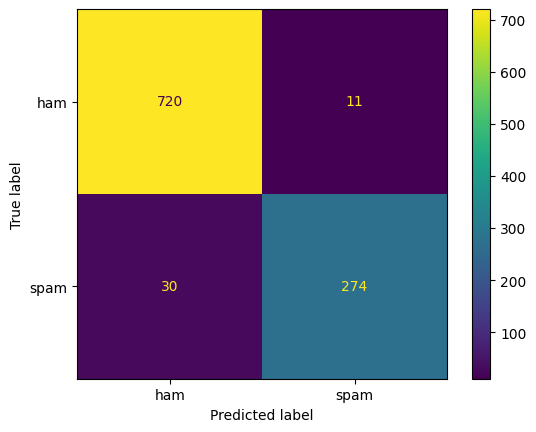

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred_test = spam_detection.predict(Vectorizer.transform(X_test))

print(f"accuracy score on test data: {accuracy_score(y_test, y_pred_test):.4f}")

print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)

ConfusionMatrixDisplay(cm, display_labels=['ham','spam']).plot();

In [27]:
classes = {0: 'non-spam', 1: 'spam'}

In [28]:
my_email_1 = "hey, you have won an exciting prize. to avail the prize click on the link below."

prediction = spam_detection.predict(Vectorizer.transform([my_email_1])).item()

classes[prediction]

'spam'

In [29]:
my_email_2 = "the revenue of the company abc is down. this is the plan to increase the revenue. please let me know your thoughts."

prediction = spam_detection.predict(Vectorizer.transform([my_email_2])).item()

classes[prediction]

'non-spam'